In [23]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from Dataset import Dataset, ELM, device
from torch.utils.data import DataLoader
torch.set_default_dtype(torch.float64)

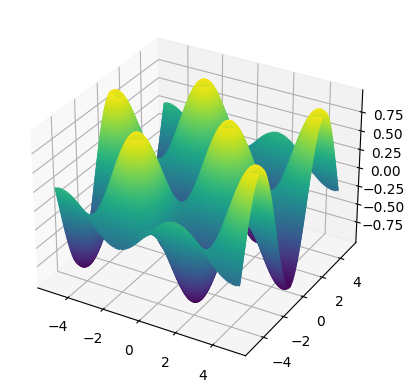

In [24]:
num_of_samples = 100
x_data = np.float64(np.linspace(-5, 5, num_of_samples))
y_data = np.float64(np.linspace(-5, 5, num_of_samples))

X, Y = np.meshgrid(x_data, y_data)
Z = np.sin(X)*np.cos(Y)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 200)
plt.show()

In [25]:
dataset = Dataset(np.concatenate((X.reshape(-1, 1), Y.reshape(-1, 1)), axis=1), Z.reshape(-1, 1))

intersize, testsize = 70, 100
interset, trainset, testset = torch.utils.data.random_split(dataset, [intersize, len(dataset)-intersize-testsize, testsize], generator=torch.Generator().manual_seed(42)) # 0.1=3000

trainloader = DataLoader(trainset, batch_size=256, shuffle=True)
testloader = DataLoader(testset, batch_size=256, shuffle=False)

activation = nn.Sigmoid()

In [26]:
# model = ELM(2, 100, 1).to(device)

# V = activation(model.fc1.bias.data.reshape(-1, 1) + model.fc1.weight.data @ interset[:][0].T.to(device))
# H = torch.concatenate([torch.ones(1, len(interset)).to(device), V.to(device)], dim=0).T
# T = interset[:][1].reshape(1, -1).T.to(device)
# W2 = torch.linalg.pinv(H) @ T.reshape(1, -1, 1)
# model.fc2.bias.data, model.fc2.weight.data = W2[0][0], W2[0][1:].T

In [28]:
# fig, ax = plt.subplots(1, 2, figsize=(15, 5))
max_train_error = []
min_train_error = []
max_test_error = []
min_test_error = []
num_neurons = 200
a = [5, 10, 50, 100, 500, 1000]
for j in a:
    print(j)
    train_error = []
    test_error = []
    for i in range(10):
        model = ELM(2, j, 1).to(device)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-10)
        intersize = j
        interset, trainset, testset = torch.utils.data.random_split(dataset, [intersize, len(dataset)-intersize-testsize, testsize], generator=torch.Generator().manual_seed(42))
        trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
        testloader = DataLoader(testset, batch_size=128, shuffle=False)
        V = activation(model.fc1.bias.data.reshape(-1, 1) + model.fc1.weight.data @ interset[:][0].T.to(device))
        H = torch.concatenate([torch.ones(1, len(interset)).to(device), V.to(device)], dim=0).T
        T = interset[:][1].reshape(1, -1).T.to(device)
        # P = torch.linalg.inv(H.T @ H + 1e-3*torch.eye(H.shape[1]).to(device))
        # W2 = P @ H.T @ T.reshape(1, -1, 1)
        W2 = torch.linalg.pinv(H) @ T.reshape(1, -1, 1)
        model.fc2.bias.data, model.fc2.weight.data = W2[0][0], W2[0][1:].T
        num_epochs = 500
        model.train()
        for epoch in range(num_epochs):
            for x, y in trainloader:
                optimizer.zero_grad()
                x, y = x.reshape(-1, 2).to(device), y.reshape(-1, 1).to(device)
                preds = model(x).to(device)
                loss = criterion(preds, y)
                loss.backward()
                optimizer.step()
        train_error.append((model(trainset[:][0].clone().detach().reshape(-1, 2).to(device))-trainset[:][1].reshape(-1, 1).to(device)).reshape(-1).pow(2).mean())
        test_error.append((model(testset[:][0].clone().detach().reshape(-1, 2).to(device))-testset[:][1].reshape(-1, 1).to(device)).reshape(-1).pow(2).mean())
    max_train_error.append(max(train_error).item())
    min_train_error.append(min(train_error).item())
    max_test_error.append(max(test_error).item())
    min_test_error.append(min(test_error).item())
# ax[0].plot([5*i+5 for i in range(num_neurons)], max_train_error, 'r', label='Błąd maksymalny')
# ax[0].plot([5*i+5 for i in range(num_neurons)], min_train_error, 'b', label='Błąd minimalny')
# ax[0].set_ylabel('Błąd średniokwadratowy zbioru uczącego')
# ax[0].set_xlabel('Liczba neuronów')
# ax[0].set_yscale('log')
# ax[0].grid()
# ax[0].legend(loc='upper right')
# ax[1].plot([5*i+5 for i in range(num_neurons)], max_test_error, 'r', label='Błąd maksymalny')
# ax[1].plot([5*i+5 for i in range(num_neurons)], min_test_error, 'b', label='Błąd minimalny')
# ax[1].set_ylabel('Błąd średniokwadratowy zbioru weryfikującego')
# ax[1].set_xlabel('Liczba neuronów')
# ax[1].set_yscale('log')
# ax[1].grid()
# ax[1].legend(loc='upper right')
# plt.show()
from decimal import Decimal
for i in min_test_error:
    print(f'{Decimal(i):.2e}', end=' & ')

5
10
50
100
500
1000
6.79e-1 & 4.00e-1 & 2.09e-1 & 1.15e-3 & 1.69e-9 & 4.14e-11 & 

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-20)

Epoch: [1/1000], loss: 0.038129
Epoch: [2/1000], loss: 0.025181
Epoch: [3/1000], loss: 0.073440
Epoch: [4/1000], loss: 0.038696
Epoch: [5/1000], loss: 0.202123
Epoch: [6/1000], loss: 0.061866
Epoch: [7/1000], loss: 0.092335
Epoch: [8/1000], loss: 0.029878
Epoch: [9/1000], loss: 0.066610
Epoch: [10/1000], loss: 0.064259
Epoch: [11/1000], loss: 0.058242
Epoch: [12/1000], loss: 0.031815
Epoch: [13/1000], loss: 0.096519
Epoch: [14/1000], loss: 0.118277
Epoch: [15/1000], loss: 0.053311
Epoch: [16/1000], loss: 0.129201
Epoch: [17/1000], loss: 0.076288
Epoch: [18/1000], loss: 0.024714
Epoch: [19/1000], loss: 0.126528
Epoch: [20/1000], loss: 0.076697
Epoch: [21/1000], loss: 0.017190
Epoch: [22/1000], loss: 0.046989
Epoch: [23/1000], loss: 0.014502
Epoch: [24/1000], loss: 0.059546
Epoch: [25/1000], loss: 0.051004
Epoch: [26/1000], loss: 0.122146
Epoch: [27/1000], loss: 0.029854
Epoch: [28/1000], loss: 0.089217
Epoch: [29/1000], loss: 0.031352
Epoch: [30/1000], loss: 0.029913
Epoch: [31/1000], l

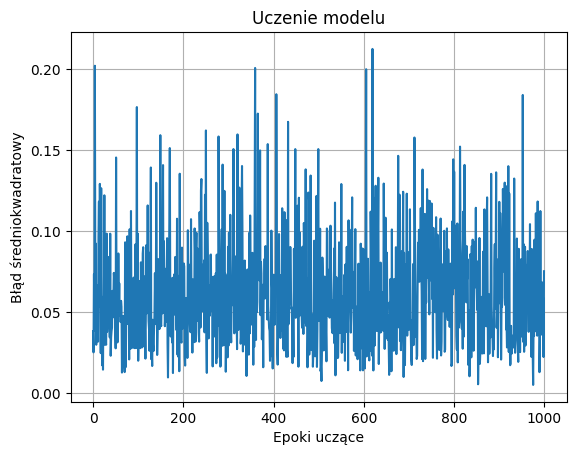

In [ ]:
num_epochs = 1000
all_losses = []
model.train()

for epoch in range(num_epochs):
    for i, (x, y) in enumerate(trainloader):
        optimizer.zero_grad()
        x, y = x.reshape(-1, 2).to(device), y.reshape(-1, 1).to(device)
        preds = model(x).to(device)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()
    all_losses.append(loss.item())
    print(f'Epoch: [{epoch+1}/{num_epochs}], loss: {loss.item():.6f}')

plt.plot(all_losses)
# plt.yscale('log')
plt.title('Uczenie modelu')
plt.xlabel('Epoki uczące')
plt.ylabel('Błąd średniokwadratowy')
plt.grid()
plt.show()

Train error: 0.06255870872022413
Test error: 0.03246330166148548


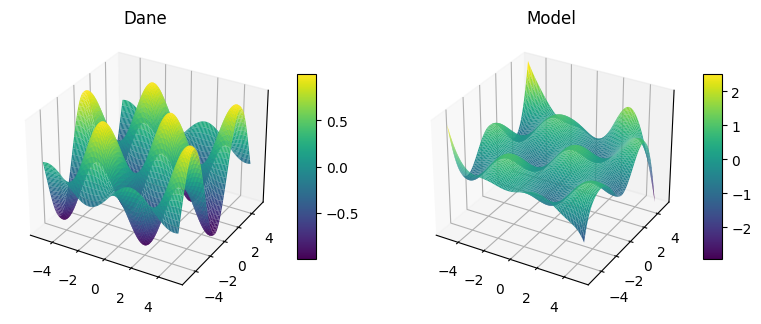

In [ ]:
print(f'Train error: {(model(trainset[:][0].clone().detach().reshape(-1, 2).to(device))-trainset[:][1].reshape(-1, 1).to(device)).reshape(-1).pow(2).mean()}')
print(f'Test error: {(model(testset[:][0].clone().detach().reshape(-1, 2).to(device))-testset[:][1].reshape(-1, 1).to(device)).reshape(-1).pow(2).mean()}')
X, Y = np.meshgrid(x_data, y_data)
fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(1, 2, 1, projection='3d')
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis')
ax.set_zticks([])
ax.set_title('Dane')
fig.colorbar(surf, shrink=0.5, aspect=10)
ax = fig.add_subplot(1, 2, 2, projection='3d')
surf = ax.plot_surface(X, Y, model(torch.cat((torch.Tensor(X).reshape(-1, 1), torch.Tensor(Y).reshape(-1, 1)), axis=1).to(device)).cpu().detach().numpy().reshape(num_of_samples, num_of_samples), rstride=1, cstride=1, cmap='viridis')
ax.set_zticks([])
ax.set_title('Model')
fig.colorbar(surf, shrink=0.5, aspect=10)
plt.show()

In [ ]:
predictions = model(torch.cat((torch.Tensor(X).reshape(-1, 1), torch.Tensor(Y).reshape(-1, 1)), axis=1).to(device)).cpu().detach().numpy().reshape(-1)
trace1 = go.Scatter3d(
    x=X.reshape(-1),
    y=Y.reshape(-1),
    z=Z.reshape(-1) - predictions,
    mode='markers',
    marker=dict(
        size=2,
        color=Z.reshape(-1) - predictions,
        colorscale='Viridis',
        colorbar=dict(title='Data - predicitions'),
    ),
    name='Model'
)
fig = go.Figure(data=[trace1], layout=dict(width=700, height=500))
fig.update_layout(
    scene = dict(
        xaxis = dict(range=[-5,5]),
        yaxis = dict(range=[-5,5]),
        zaxis = dict(range=[-0.1,0.1]),),
    width=700,
    margin=dict(r=20, l=10, b=10, t=10)
)
fig.show()

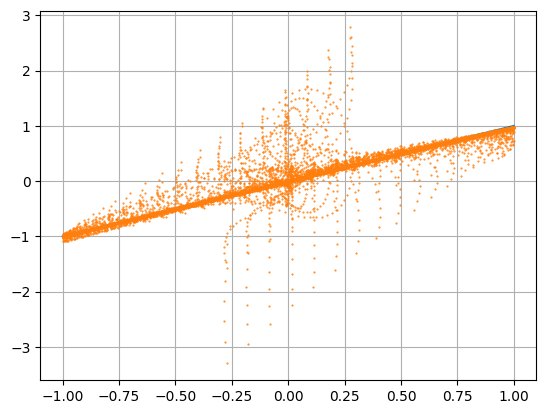

In [ ]:
plt.plot([np.min(Z), np.max(Z)], [np.min(Z), np.max(Z)])
plt.plot(Z.reshape(-1), model(torch.cat((torch.Tensor(X).reshape(-1, 1), torch.Tensor(Y).reshape(-1, 1)), axis=1).to(device)).cpu().detach().numpy().reshape(-1), '.', markersize=1)
plt.grid()
plt.show()